# はじめに
表形式データの分類モデルを構築します。

### 概要
- adultデータセットを用いて収入を予測するモデルを構築します。
- モデルはTabNetを使用します。

# TabNet
TabNetは表形式データのために提案されたニューラルネットワークです。  
下記の提案論文の図に示されている通り、モデルの主な特徴は2点あります。  
1. Attentive Transformerという機構を利用して、入力の少数の特徴を選択して予測
2. 上記を繰り返し、各予測を統合して全体の予測結果とする。ただし、2回目以降は、前回の予測も入力に加える。





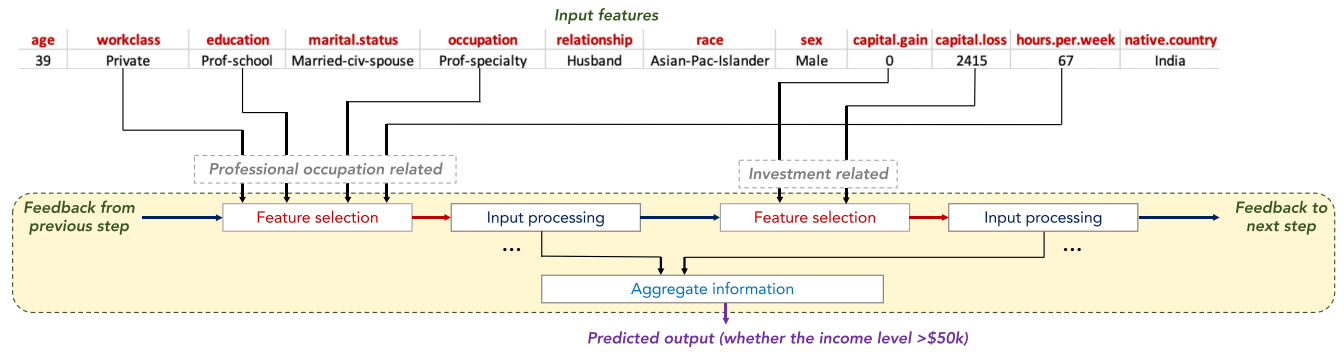

# 実装
### 1. ライブラリのインポート
TabNetはpytorch_tabularの実装を使用します。

In [ ]:
!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo

!pip install pytorch_tabular

import sys
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import collections
from sklearn.model_selection import train_test_split
from sklearn import metrics

import torch
import torch.nn as nn
import torch.nn.functional as F


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.4/160.4 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 777.7/777.7 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 28.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 4.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.6 MB/s eta 0:00:00
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=936d2ec7c67e7503ae5692ea23c879abc0d2f346b5570c1163af33b446c0dc73
  Stored in directory: /root/.cache/pip/wheels

### 2. 実行環境の確認
使用するライブラリのバージョンや、GPU環境を確認します。  

In [ ]:
print('Python:', sys.version)
print('PyTorch:', torch.__version__)
!nvidia-smi

Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
PyTorch: 2.1.0+cu121
Sat Jan 20 05:20:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |            

### 3. データセットの用意
adultデータセットをダウンロードして、学習に使用できる形式に整形します。

In [ ]:
adult = fetch_ucirepo(id=2)

X = adult.data.features
y = adult.data.targets['income']

y = y.replace({'<=50K.': 0, '<=50K':0, '>50K.': 1, '>50K': 1})

# カテゴリ変数の特定
categorical = X.columns[X.dtypes == 'object'].tolist()
continuous = X.columns[X.dtypes != 'object'].tolist()


# 教師データとテストデータにランダムに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape)
print(collections.Counter(y_train), collections.Counter(y_test))

X_train['income'] = y_train
X_test['income'] = y_test


(34189, 14) (14653, 14)
Counter({0: 26046, 1: 8143}) Counter({0: 11109, 1: 3544})


### 4. ニューラルネットワークの定義  
学習などの設定は、configに引数として渡し、TabularModelを作成します。

In [ ]:
from pytorch_tabular import TabularModel
from pytorch_tabular.models import TabNetModelConfig
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig

data_config = DataConfig(
    target=['income'],
    continuous_cols=continuous,
    categorical_cols=categorical,
)
trainer_config = TrainerConfig(
    auto_lr_find=False,
    batch_size=128,
    max_epochs=100,
)
optimizer_config = OptimizerConfig(
    optimizer_params = {'weight_decay':1e-4}
)
model_config = TabNetModelConfig(
    task="classification",
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)


INFO:pytorch_tabular.tabular_model:Experiment Tracking is turned off


### 5. 学習
ニューラルネットワークの学習を行います。  


In [ ]:
tabular_model.fit(train=X_train)

INFO:lightning_fabric.utilities.seed:Seed set to 42
INFO:pytorch_tabular.tabular_model:Preparing the DataLoaders
INFO:pytorch_tabular.tabular_datamodule:Setting up the datamodule for classification task
INFO:pytorch_tabular.tabular_model:Preparing the Model: TabNetModel
INFO:pytorch_tabular.tabular_model:Preparing the Trainer
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_tabular.tabular_model:Training Started
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name             ┃ Type             ┃ Params ┃
┡━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ _embedding_layer │ Identity         │      0 │
│ 1 │ _backbone        │ TabNetBackbone   │  9.8 K │
│ 2 │ _head            │ Identity         │      0 │
│ 3 │ loss             │ CrossEntropyLoss │      0 │
└───┴──────────────────┴──────────────────┴────────┘

Trainable params: 9.8 K                                                                                            
Non-trainable params: 0                                                                                            
Total params: 9.8 K                                                                                                
Total estimated model params size (MB): 0

Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 
'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 
'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the 
`num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.

INFO:pytorch_tabular.tabular_model:Training the model completed
INFO:pytorch_tabular.tabular_model:Loading the best model


### 6. 学習結果の表示
テストデータの損失と精度を評価します。

In [ ]:
res = tabular_model.evaluate(X_test)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Output()

/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=1` in the `DataLoader` to improve performance.


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.8428308367729187     │
│         test_loss         │    0.3377942144870758     │
└───────────────────────────┴───────────────────────────┘

# おわりに
### 今回の結果
今回の設定では、テスト精度は84%程度となりました。  
全結合ニューラルネットワークよりも少し低い結果となっています。  
ただし、データセットやハイパーパラメータによっても性能は異なるため、もう少し検証は必要です。  


### 次にやること
他の表形式データのために提案されたニューラルネットワークも試してみようと思います。

# 参考資料  
- S. O. Arik and T. Pfister, TabNet: Attentive Interpretable Tabular Learning, AAAI, 2021.
- PyTorch Tabular  
https://pytorch-tabular.readthedocs.io/en/latest/